In [1]:
# ================================
# THIS SCRIPT LOADS DATA FROM MSSQL, FITS A PROPHET MODEL,
# PERFORMS ADAPTIVE CROSS-VALIDATION, FORECASTS FUTURE VALUES,
# AND PUSHES THE RESULTS BACK TO MSSQL.
# IT ALSO PLOTS THE FORECAST WITH TOTAL FORECASTED VALUE.
# ================================

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pyodbc
from sqlalchemy import create_engine
import numpy as np


Importing plotly failed. Interactive plots will not work.


In [2]:
# ================================
# CONFIGURATION
# ================================
CONFIG = {
    # --- MSSQL PULL ---
    'sql_query': """
        SELECT 
            trandate_ddmmyyyy AS order_date, 
            NetSales 
        FROM _Gift_from_Carpenters 
        WHERE NetSales IS NOT NULL
    """,
    'server': '100.99.225.51',
    'database': 'TEST1',
    'username': 'SA',
    'password': 'a31536000',
    'driver': '{ODBC Driver 17 for SQL Server}',
    'encrypt': 'yes',
    'trust_server_certificate': 'yes',

    # --- TIMEOUTS (Critical for bulk ops) ---
    'connection_timeout': 120,   # 2 minutes
    'query_timeout': 300,        # 5 minutes

    # --- FORECAST SETTINGS ---
    'date_column': None,
    'value_column': None,
    'date_format': '%d/%m/%Y',
    'aggregation_freq': 'D',           # D, W, M
    'forecast_periods': 365,

    # --- CROSS-VALIDATION ---
    'cv_initial': '3D',
    'cv_period': '1D',
    'cv_horizon': '4D',

    # --- PUSH ---
    'target_table': 'sales_forecasted_data',

    # --- PLOT ---
    'plot_title': 'Sales Forecast (_Gift_from_Carpenters)',
    'plot_xlabel': 'Date',
    'plot_ylabel': 'Sales (USD)'
}

# Frequency mapping
FREQ_MAP_RESAMPLE = {'D': 'D', 'W': 'W-MON', 'M': 'MS'}
FREQ_MAP_PROPHET = {'D': 'D', 'W': 'W', 'M': 'MS'}

In [3]:
# ================================
# 1. LOAD FROM MSSQL
# ================================
def load_data(config):
    conn_str = (
        f"DRIVER={config['driver']};"
        f"SERVER={config['server']};"
        f"DATABASE={config['database']};"
        f"UID={config['username']};"
        f"PWD={config['password']};"
        f"Encrypt={config['encrypt']};"
        f"TrustServerCertificate={config['trust_server_certificate']};"
    )
    try:
        print("Connecting to MSSQL...")
        conn = pyodbc.connect(conn_str)
        df = pd.read_sql(config['sql_query'], conn)
        conn.close()
        print(f"Loaded {len(df):,} rows from DB")

        # Auto-detect
        date_col = config['date_column'] or 'order_date'
        value_col = config['value_column'] or 'NetSales'

        df[date_col] = pd.to_datetime(df[date_col], format=config['date_format'], errors='coerce')
        df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
        df = df.dropna(subset=[date_col, value_col])

        print(f"Cleaned data: {len(df):,} rows")
        return df, date_col, value_col
    except Exception as e:
        print(f"DB Load Failed: {e}")
        return None, None, None


In [4]:
# ================================
# 2. AGGREGATE
# ================================
def aggregate_data(df, date_col, value_col, freq):
    try:
        agg_df = df.groupby(date_col)[value_col].sum().reset_index()
        agg_df.columns = ['ds', 'y']
        if freq != 'D':
            agg_df.set_index('ds', inplace=True)
            resample_freq = FREQ_MAP_RESAMPLE.get(freq, 'D')
            agg_df = agg_df.resample(resample_freq).sum().reset_index()
            agg_df['y'] = agg_df['y'].fillna(0)
        return agg_df
    except Exception as e:
        print(f"Aggregation error: {e}")
        return None


In [5]:
# ================================
# 3. FIT MODEL
# ================================
def fit_prophet_model(df):
    try:
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        model.fit(df)
        return model
    except Exception as e:
        print(f"Model fit error: {e}")
        return None


In [6]:
# ================================
# 4. FORECAST
# ================================
def make_forecast(model, periods, freq):
    try:
        prophet_freq = FREQ_MAP_PROPHET.get(freq, 'D')
        future = model.make_future_dataframe(periods=periods, freq=prophet_freq)
        forecast = model.predict(future)
        return forecast
    except Exception as e:
        print(f"Forecast error: {e}")
        return None

In [7]:
# ================================
# 5. CROSS-VALIDATION (ADAPTIVE)
# ================================
def run_cross_validation(model, config, agg_df):
    try:
        print("\n" + "="*60)
        print("CROSS-VALIDATION")
        print("="*60)

        data_span = (agg_df['ds'].max() - agg_df['ds'].min()).days
        horizon_days = int(config['cv_horizon'].replace('D', ''))
        initial_days = int(config['cv_initial'].replace('D', ''))

        min_needed = initial_days + horizon_days
        if data_span < min_needed:
            scale = data_span / min_needed * 0.8
            initial_days = max(180, int(initial_days * scale))
            horizon_days = max(30, int(horizon_days * scale))
            print(f"Data too short → Adjusted: initial={initial_days}D, horizon={horizon_days}D")

        df_cv = cross_validation(
            model,
            initial=f"{initial_days}D",
            period=config['cv_period'],
            horizon=f"{horizon_days}D",
            parallel="processes"
        )
        df_perf = performance_metrics(df_cv)

        print(f"CV Success: {len(df_cv)} predictions")
        print(f"MAE: {df_perf['mae'].mean():,.2f} | MAPE: {df_perf['mape'].mean():.2%}")
        return df_cv, df_perf
    except Exception as e:
        print(f"CV Failed: {e}")
        return None, None

In [8]:

# ================================
# 6. PUSH TO DB
# ================================
def push_forecast_to_db(future_forecast, config):
    conn_str = (
        f"DRIVER={config['driver']};"
        f"SERVER={config['server']};"
        f"DATABASE={config['database']};"
        f"UID={config['username']};"
        f"PWD={config['password']};"
        f"Encrypt={config['encrypt']};"
        f"TrustServerCertificate={config['trust_server_certificate']};"
    )
    try:
        conn = pyodbc.connect(conn_str)
        cursor = conn.cursor()

        table = config['target_table']
        cursor.execute(f"""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = '{table}')
            CREATE TABLE {table} (
                forecast_date DATE PRIMARY KEY,
                yhat FLOAT,
                yhat_lower FLOAT,
                yhat_upper FLOAT,
                created_at DATETIME DEFAULT GETDATE()
            )
        """)
        cursor.execute(f"TRUNCATE TABLE {table}")
        conn.commit()

        # Push via SQLAlchemy (fast bulk)
        engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str.replace(';', '%3B')}")
        future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'forecast_date'}).to_sql(
            table, engine, if_exists='append', index=False, method='multi'
        )
        conn.close()
        print(f"Pushed {len(future_forecast)} rows to `{table}`")
    except Exception as e:
        print(f"Push failed: {e}")

In [9]:
# ================================
# 7. PLOT
# ================================
def plot_forecast(model, forecast, agg_df, title, xlabel, ylabel):
    try:
        fig = model.plot(forecast)
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
        model.plot_components(forecast)
        plt.show()
        return fig
    except Exception as e:
        print(f"Plot error: {e}")
        return None


In [10]:
# ================================
# 8. TRAINING & VALIDATION METRICS
# ================================
def print_metrics(model, forecast, agg_df, cv_results):
    try:
        # --- TRAINING METRICS ---
        train_pred = forecast[forecast['ds'].isin(agg_df['ds'])].copy()
        train_actual = agg_df.set_index('ds')['y']
        train_pred = train_pred.set_index('ds')['yhat']
        train_pred = train_pred.reindex(train_actual.index).fillna(0)

        mae_train = mean_absolute_error(train_actual, train_pred)
        mape_train = np.mean(np.abs((train_actual - train_pred) / train_actual.replace(0, np.nan))) * 100
        rmse_train = np.sqrt(mean_squared_error(train_actual, train_pred))

        print("\n" + "="*50)
        print("TRAINING METRICS (In-Sample Fit)")
        print("="*50)
        print(f"MAE : {mae_train:,.2f}")
        print(f"MAPE: {mape_train:,.2f}%")
        print(f"RMSE: {rmse_train:,.2f}")

        # --- VALIDATION METRICS (from CV) ---
        if cv_results is not None:
            df_perf = performance_metrics(cv_results)
            print("\n" + "="*50)
            print("VALIDATION METRICS (Cross-Validation)")
            print("="*50)
            print(f"MAE : {df_perf['mae'].mean():,.2f}")
            print(f"MAPE: {df_perf['mape'].mean():,.2f}%")
            print(f"RMSE: {df_perf['rmse'].mean():,.2f}")
        else:
            print("\nValidation metrics skipped (CV failed)")

    except Exception as e:
        print(f"Metrics error: {e}")

In [11]:
def main(config):
    df, date_col, value_col = load_data(config)
    if df is None: return
    agg_df = aggregate_data(df, date_col, value_col, config['aggregation_freq'])
    if agg_df is None: return
    model = fit_prophet_model(agg_df)
    if model is None: return
    forecast = make_forecast(model, config['forecast_periods'], config['aggregation_freq'])
    if forecast is None: return

    # CV
    cv_results, _ = run_cross_validation(model, config, agg_df)

    # METRICS
    print_metrics(model, forecast, agg_df, cv_results)

    # Total Forecast
    future = forecast[~forecast['ds'].isin(agg_df['ds'])].copy()
    total = future['yhat'].sum()
    print(f"\nTOTAL FORECAST ({config['forecast_periods']} days): ${total:,.2f}")

    # Push
    push_forecast_to_db(future, config)

    # Plot
    fig = plot_forecast(model, forecast, agg_df, config['plot_title'], config['plot_xlabel'], config['plot_ylabel'])
    if fig:
        ax = fig.axes[0]
        ax.axhline(total, color='green', linestyle='--', label=f'Total: ${total:,.0f}')
        ax.text(forecast['ds'].max(), total, f' ${total:,.0f}', color='green', fontweight='bold')
        ax.legend()
        plt.show()

Connecting to MSSQL...


C:\Users\Fau\AppData\Local\Temp\ipykernel_36388\1929062489.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(config['sql_query'], conn)


02:56:10 - cmdstanpy - INFO - Chain [1] start processing


Loaded 27,174 rows from DB
Cleaned data: 27,174 rows


02:56:11 - cmdstanpy - INFO - Chain [1] done processing



CROSS-VALIDATION
Data too short → Adjusted: initial=180D, horizon=30D
CV Failed: Less data than horizon.

TRAINING METRICS (In-Sample Fit)
MAE : 0.04
MAPE: 0.00%
RMSE: 0.04

Validation metrics skipped (CV failed)

TOTAL FORECAST (365 days): $36,097,741,366.73


Pushed 365 rows to `sales_forecasted_data`


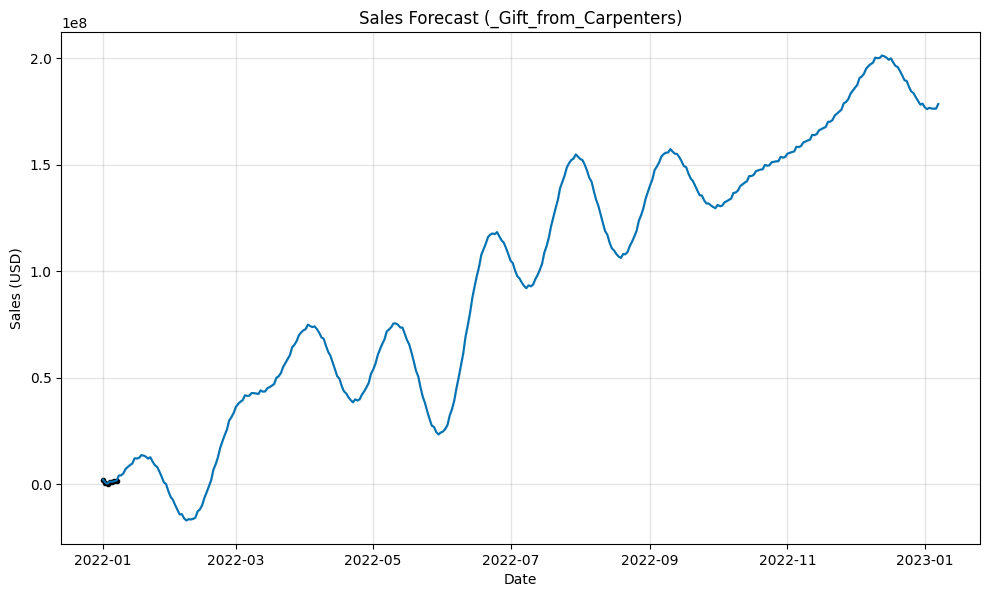

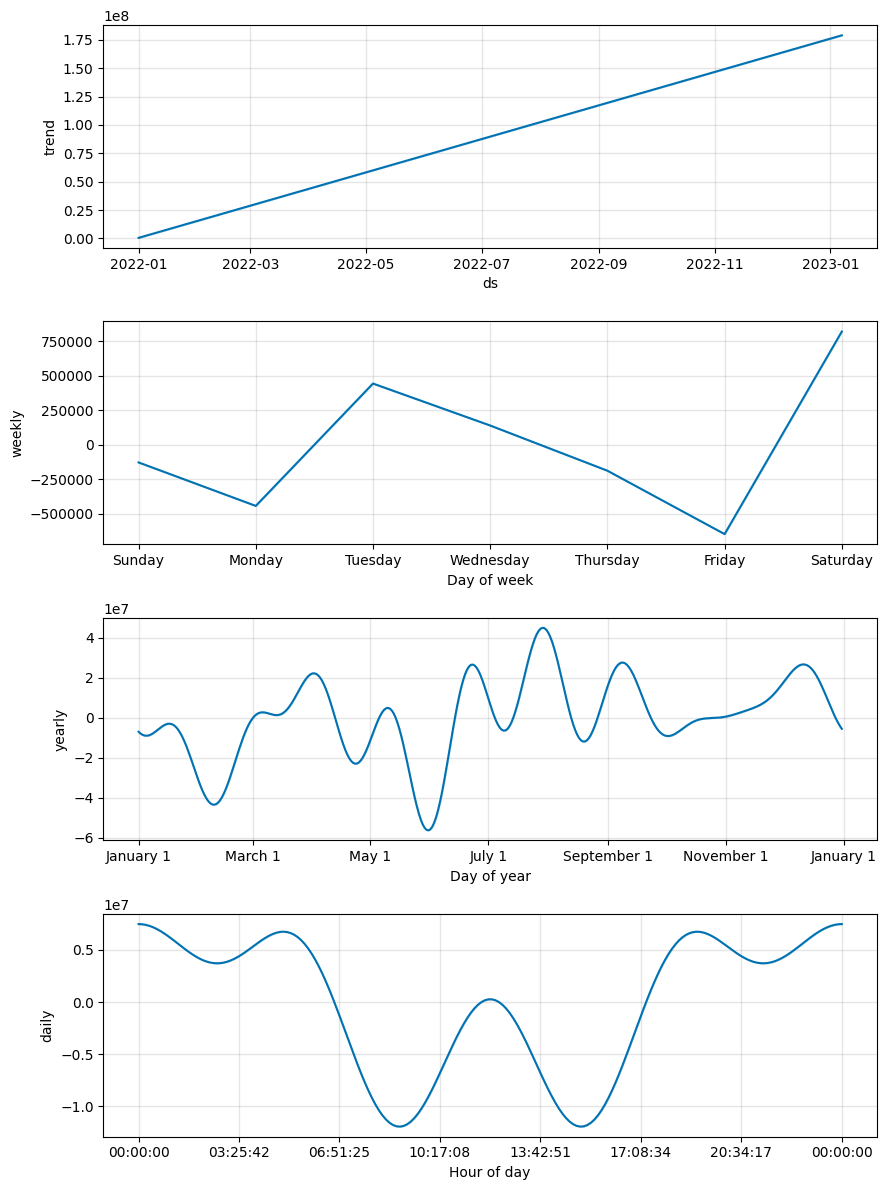

In [12]:
if __name__ == "__main__":
    main(CONFIG)